In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import torchvision.transforms as T

In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Ötüntü.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/Ötüntü.zip
   creating: Ötüntü/
   creating: Ötüntü/Test/
  inflating: Ötüntü/Test/image_2024-05-27_16-41-31_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_16-41-31_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_16-52-13_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_16-52-13_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-02-54_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-02-54_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-13-36_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-13-36_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-24-18_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-24-18_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-35-00_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-35-00_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-45-41_0.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-45-41_1.jpg  
  inflating: Ötüntü/Test/image_2024-05-27_17-56-23_0.jpg  
  inf

In [3]:

# List of file paths to combine
file_paths = [
    '/content/Ötüntü/Train/Virus_IR_Set2_Segment54_001regression.csv',
    '/content/Ötüntü/Train/Virus_IR_Set2_Segment54_005_001regression.csv',
    '/content/Ötüntü/Train/Virus_IR_Set2_Segment54_0099regression.csv',
    '/content/Ötüntü/Train/Virus_IR_Set2_Segment54_009regression.csv'
]

# Create an empty list to store dataframes
dfs = []

# Read each CSV file and append its dataframe to the list
for file_path in file_paths:
  try:
    df = pd.read_csv(file_path)
    dfs.append(df)
  except FileNotFoundError:
    print(f"Warning: File not found at {file_path}. Skipping.")
  except Exception as e:
    print(f"An error occurred while reading {file_path}: {e}. Skipping.")


# Combine the dataframes
if dfs:
  combined_df = pd.concat(dfs, ignore_index=True)

  # Define the output path
  output_path = '/content/Ötüntü/combined_regression_data.csv'

  # Save the combined dataframe to a new CSV file
  combined_df.to_csv(output_path, index=False)

  print(f"Combined data saved to {output_path}")
else:
  print("No dataframes were successfully loaded. No combined file was created.")


Combined data saved to /content/Ötüntü/combined_regression_data.csv


In [4]:
# prompt: transfer files inde  /content/Ötüntü/Valid to /content/Ötüntü/Train

import shutil

valid_dir = '/content/Ötüntü/Valid'
train_dir = '/content/Ötüntü/Train'

# Create the train directory if it doesn't exist
os.makedirs(train_dir, exist_ok=True)

# List all items (files and directories) in the source directory
items_to_transfer = os.listdir(valid_dir)

# Transfer each item from 'Valid' to 'Train'
for item_name in items_to_transfer:
  source_item = os.path.join(valid_dir, item_name)
  destination_item = os.path.join(train_dir, item_name)

  # Check if it's a file and transfer it
  if os.path.isfile(source_item):
    try:
      shutil.move(source_item, destination_item)
      print(f"Transferred file: {item_name}")
    except Exception as e:
      print(f"Error transferring file {item_name}: {e}")
  # You can also handle directories if needed
  # elif os.path.isdir(source_item):
  #     try:
  #         shutil.move(source_item, destination_item)
  #         print(f"Transferred directory: {item_name}")
  #     except Exception as e:
  #         print(f"Error transferring directory {item_name}: {e}")


print("File transfer from Valid to Train complete.")

Transferred file: image_2024-05-28_11-35-39_1.jpg
Transferred file: image_2024-05-28_13-33-22_2.jpg
Transferred file: image_2024-05-27_22-45-07_1.jpg
Transferred file: image_2024-05-28_15-31-04_0.jpg
Transferred file: image_2024-05-28_11-46-21_1.jpg
Transferred file: image_2024-05-27_19-21-56_1.jpg
Transferred file: image_2024-05-28_15-20-22_0.jpg
Transferred file: image_2024-05-27_18-28-28_1.jpg
Transferred file: image_2024-05-28_15-52-28_1.jpg
Transferred file: image_2024-05-28_09-16-32_0.jpg
Transferred file: image_2024-05-27_20-36-47_0.jpg
Transferred file: image_2024-05-28_08-55-08_2.jpg
Transferred file: image_2024-05-27_22-34-26_0.jpg
Transferred file: image_2024-05-27_20-58-11_1.jpg
Transferred file: image_2024-05-27_17-35-00_1.jpg
Transferred file: image_2024-05-27_21-51-39_1.jpg
Transferred file: image_2024-05-28_09-05-50_0.jpg
Transferred file: image_2024-05-27_21-08-53_1.jpg
Transferred file: image_2024-05-28_09-16-32_2.jpg
Transferred file: image_2024-05-28_14-16-10_1.jpg


In [5]:
import os
import shutil
import pandas as pd
import numpy as np

# 1) Ayarlar
test_dir          = '/content/Ötüntü/Test'
train_dir         = '/content/Ötüntü/Train'
valid_images_dir  = '/content/Ötüntü/Valid/images'
valid_masks_dir   = '/content/Ötüntü/Valid/valid'
csv_path          = '/content/Ötüntü/combined_regression_data.csv'
transfer_fraction = 0.2

# Klasörleri oluştur (eğer yoksa)
os.makedirs(valid_images_dir, exist_ok=True)
os.makedirs(valid_masks_dir,  exist_ok=True)

# 2) Dosya listelerini al
test_imgs  = {f for f in os.listdir(test_dir)  if os.path.isfile(os.path.join(test_dir, f))}
train_imgs = {f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))}

# 3) Unique (eşsiz) dosyaları bul ve sil
unique_imgs = (test_imgs - train_imgs) | (train_imgs - test_imgs)
print(f"Silinecek unique dosya sayısı: {len(unique_imgs)}")

# Klasörlerden sil
for fname in unique_imgs:
    if fname in test_imgs:
        os.remove(os.path.join(test_dir, fname))
    if fname in train_imgs:
        os.remove(os.path.join(train_dir, fname))
print("Unique dosyalar klasörlerden silindi.")

# CSV’den sil
df = pd.read_csv(csv_path)
initial_rows = len(df)
df = df[~df['Image Name'].isin(unique_imgs)]
rows_deleted = initial_rows - len(df)
print(f"CSV’den silinen satır: {rows_deleted}")
df.to_csv(csv_path, index=False)
print("CSV güncellendi; unique dosyalar çıkarıldı.")

# 4) Güncellenmiş Test/Train kümelerini al ve ortakları belirle
test_imgs  = {f for f in os.listdir(test_dir)  if os.path.isfile(os.path.join(test_dir, f))}
train_imgs = {f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))}
common     = sorted(test_imgs & train_imgs)
print(f"Artık Test ∩ Train: {len(common)} dosya")

if len(common) == 0:
    raise RuntimeError("Test ve Train klasörlerinde ortak dosya kalmadı!")

# 5) Ortakların %20’sini valid’e taşı
n_transfer = int(len(common) * transfer_fraction)
np.random.seed(42)
to_transfer = np.random.choice(common, n_transfer, replace=False)
print(f"%{int(transfer_fraction*100)} ({n_transfer}) dosya Valid’e taşınıyor...")

for fname in to_transfer:
    shutil.move(os.path.join(test_dir, fname),
                os.path.join(valid_images_dir, fname))
    shutil.move(os.path.join(train_dir, fname),
                os.path.join(valid_masks_dir,  fname))
print("Taşıma tamam.")

# 6) Son kontrol: Test vs Train eşit mi?
final_test  = {f for f in os.listdir(test_dir)  if os.path.isfile(os.path.join(test_dir, f))}
final_train = {f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))}

if final_test == final_train:
    print("✅ Son kontrol: Test ve Train artık tamamen eşleşiyor.")
else:
    print("⚠️ Son kontrolde hâlâ eşleşmeyen dosyalar var, lütfen kontrol edin.")


Silinecek unique dosya sayısı: 371
Unique dosyalar klasörlerden silindi.
CSV’den silinen satır: 0
CSV güncellendi; unique dosyalar çıkarıldı.
Artık Test ∩ Train: 1088 dosya
%20 (217) dosya Valid’e taşınıyor...
Taşıma tamam.
✅ Son kontrol: Test ve Train artık tamamen eşleşiyor.


# Buradan Başlıyor


In [6]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F

In [7]:
# -----------------------------
# 1) Ayarlar
# -----------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_IMG_DIR  = '/content/Ötüntü/Test'
TRAIN_MASK_DIR = '/content/Ötüntü/Train'
VALID_IMG_DIR  = '/content/Ötüntü/Valid/images'
VALID_MASK_DIR = '/content/Ötüntü/Valid/valid'
CSV_PATH       = '/content/Ötüntü/combined_regression_data.csv'

BATCH_SIZE = 8
NUM_EPOCHS = 5
LR         = 1e-4


In [8]:
# -----------------------------
# 2) Dataset
# -----------------------------
class LeafDiseaseDataset(Dataset):
    def __init__(self, img_dir, mask_dir, csv_path, transform=None):
        # Görüntü (img) ve maske (mask) dizinlerinin yollarını sakla
        self.img_dir   = img_dir
        self.mask_dir  = mask_dir
        # Kullanıcının isteğe bağlı olarak verdiği görüntü dönüşümlerini sakla
        self.transform = transform

        # 1) CSV dosyasını oku; içinde 'Image Name' ve 'Red Pixels Ratio (%)' sütunları var
        df = pd.read_csv(csv_path)

        # 2) img_dir ve mask_dir içindeki dosya adlarını al (örn. {'leaf1.png', 'leaf2.png', ...})
        imgs_avail  = set(os.listdir(img_dir))
        masks_avail = set(os.listdir(mask_dir))

        # 3) İki klasörde de bulunan dosyaları belirle
        common_files = imgs_avail & masks_avail

        # 4) CSV’deki kayıtlardan yalnızca ortak dosya adlarına sahip olanları filtrele
        self.df = df[df['Image Name'].isin(common_files)].reset_index(drop=True)

        # 5) Maske görüntüsünü resize ederken en yakın komşu (nearest) interpolasyon kullanmak için dönüşüm dizisi oluştur
        self.mask_transform = transforms.Compose([
            transforms.Resize((112,112), interpolation=InterpolationMode.NEAREST),
            transforms.ToTensor(),
            # İkili maske: piksel değeri 0.5’ten büyükse 1.0, küçükse 0.0 olacak şekilde eşik uygula
            transforms.Lambda(lambda t: (t > 0.5).float())
        ])

    def __len__(self):
        # Toplam örnek sayısı = filtrelenmiş DataFrame satır sayısı
        return len(self.df)

    def __getitem__(self, idx):
        # Verilen indeks için
        # 1) Görüntü dosya adını al
        img_name = self.df.loc[idx, 'Image Name']
        # 2) CSV’deki kırmızı piksel oranını normalize et (0–1 aralığına) ve float tensor’a çevir
        ratio    = self.df.loc[idx, 'Red Pixels Ratio (%)'] / 100.0

        # --- Görüntüyü yükleme ve ön işleme ---
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert('RGB')  # RGB formatına çevir
        # Eğer kullanıcı transform verdiyse uygula, yoksa ToTensor ile dönüştür
        img = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # --- Maske oluşturma adımları ---
        mask_path = os.path.join(self.mask_dir, img_name)
        mask_pil  = Image.open(mask_path).convert('RGB')  # Maske görüntüsünü yükle
        arr       = np.array(mask_pil)                    # NumPy dizisine çevir

        # Kırmızı alanı tespit et:
        #   - Kırmızı kanalı > 128
        #   - Yeşil ve Mavi kanalları < 50
        red_mask  = (arr[:,:,0] > 128) & (arr[:,:,1] < 50) & (arr[:,:,2] < 50)
        # Boolean maskeyi 0–255 aralığına dönüştür, PIL görüntüsü yap
        mask_pil2 = Image.fromarray((red_mask * 255).astype(np.uint8))
        # Önceden tanımlı mask_transform’u uygula (resize, tensor, eşik)
        mask      = self.mask_transform(mask_pil2)

        # Son olarak görüntü, maske ve oran tensor’ünü döndür
        return img, mask, torch.tensor([ratio], dtype=torch.float32)

In [9]:
# -----------------------------
# 3) Dataloaders
# -----------------------------
img_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = LeafDiseaseDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, CSV_PATH, transform=img_tf)
valid_ds = LeafDiseaseDataset(VALID_IMG_DIR, VALID_MASK_DIR, CSV_PATH, transform=img_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=1)
print("► Train örnek sayısı:", len(train_loader.dataset))
print("► Valid örnek sayısı:", len(valid_loader.dataset))


► Train örnek sayısı: 871
► Valid örnek sayısı: 217


Görüntü shape : torch.Size([3, 224, 224])
Maske shape   : torch.Size([1, 112, 112])
Ratio değeri  : 0.06849999725818634
Batch görüntüler shape : torch.Size([8, 3, 224, 224])
Batch maskeler shape   : torch.Size([8, 1, 112, 112])
Batch ratio tensor     : tensor([[0.1036],
        [0.0015],
        [0.1928],
        [0.0028],
        [0.0000],
        [0.0111],
        [0.0226],
        [0.2339]])


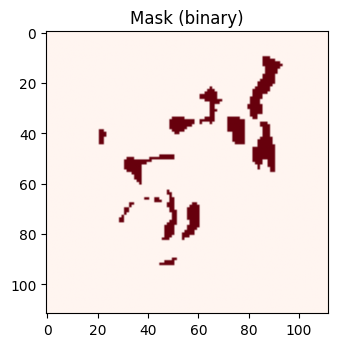

In [15]:
img, mask, ratio = train_ds[0]

print("Görüntü shape :", img.shape)      # torch.Size([3, 224, 224])
print("Maske shape   :", mask.shape)     # torch.Size([1, 112, 112])
print("Ratio değeri  :", ratio.item())   # örneğin 0.23 gibi

# 2) Bir batch örneği (DataLoader üzerinden)
# ------------------------------------------------
# train_loader’dan bir batch çek
batch_imgs, batch_masks, batch_ratios = next(iter(train_loader))

print("Batch görüntüler shape :", batch_imgs.shape)    # ([batch_size, 3,224,224])
print("Batch maskeler shape   :", batch_masks.shape)   # ([batch_size,1,112,112])
print("Batch ratio tensor     :", batch_ratios)        # ([batch_size,1])

# Dataset’ten gelen tek örneği göster:
plt.figure(figsize=(8,4))



plt.subplot(1,2,1)
# mask’i squeeze ile [H×W] yap, kırmızı tonla çiz
plt.imshow(mask.squeeze(), cmap='Reds')
plt.title(f"Mask (binary)")

plt.show()


In [ ]:
# -----------------------------
# 4) Model
# -----------------------------
class SegRegUNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        # -----------------------------
        # ENCODER (Özellik çıkarıcı) - ResNet34
        # -----------------------------
        resnet = models.resnet34(pretrained=pretrained)  # ImageNet ile ön-eğitimli ResNet34

        # İlk katmanlar (Conv + BN + ReLU)
        self.enc1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)

        # Ardışık encoder katmanları
        self.enc2 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.enc3 = resnet.layer2
        self.enc4 = resnet.layer3
        self.enc5 = resnet.layer4  # En derin (en küçük boyutlu, en zengin) özellik haritası

        # -----------------------------
        # DECODER (Segmentasyon kısmı)
        # U-Net benzeri: upsampling + concatenation + conv
        # -----------------------------
        def upconv(i, o): return nn.ConvTranspose2d(i, o, kernel_size=2, stride=2)  # Yukarı örnekleme
        def conv3x3(i, o):
            return nn.Sequential(
                nn.Conv2d(i, o, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Her decoder katmanı: upsample + concatenate + conv
        self.up5, self.dec5 = upconv(512, 256), conv3x3(512, 256)  # 256 + 256 = 512 (concat ile)
        self.up4, self.dec4 = upconv(256, 128), conv3x3(256, 128)  # 128 + 128
        self.up3, self.dec3 = upconv(128,  64), conv3x3(128,  64)  # 64 + 64
        self.up2, self.dec2 = upconv(64,   32), conv3x3(96,   32)  # 32 + 64 = 96 (e1'in kanalı 64)

        # -----------------------------
        # Segmentasyon Çıkışı (Head)
        # -----------------------------
        self.seg_head = nn.Conv2d(32, 1, kernel_size=1)  # Binary maske çıktısı, 1 kanal

        # -----------------------------
        # Regresyon Çıkışı (Head)
        # -----------------------------
        self.pool = nn.AdaptiveAvgPool2d(1)  # 512×H×W → 512×1×1, global average
        self.reg_head = nn.Sequential(
            nn.Flatten(),                  # 512×1×1 → 512
            nn.Linear(512, 64), nn.ReLU(), # Tam bağlantılı katman
            nn.Linear(64, 1), nn.Sigmoid() # [0,1] aralığında hastalık oranı tahmini
        )

    def forward(self, x):
        # -----------------------------
        # Encoder'dan özellik çıkarımı
        # -----------------------------
        e1 = self.enc1(x)     # İlk konvolüsyon + ReLU
        e2 = self.enc2(e1)    # 1. encoder bloğu
        e3 = self.enc3(e2)    # 2. encoder bloğu
        e4 = self.enc4(e3)    # 3. encoder bloğu
        e5 = self.enc5(e4)    # 4. encoder bloğu (en derin)

        # -----------------------------
        # Decoder + skip connections (U-Net mantığı)
        # -----------------------------
        d5 = self.dec5(torch.cat([self.up5(e5), e4], dim=1))  # 512 → 256, e4 ile birleştir
        d4 = self.dec4(torch.cat([self.up4(d5), e3], dim=1))  # 256 → 128, e3 ile
        d3 = self.dec3(torch.cat([self.up3(d4), e2], dim=1))  # 128 → 64,  e2 ile
        d2 = self.dec2(torch.cat([self.up2(d3), e1], dim=1))  # 96 → 32,   e1 ile

        # -----------------------------
        # Çıktılar
        # -----------------------------
        seg = self.seg_head(d2)               # Segmentasyon maskesi
        reg = self.reg_head(self.pool(e5))    # Hastalık oranı tahmini (regresyon)

        return seg, reg  # (B×1×H×W), (B×1)

# Modeli CUDA'ya yükle
model = SegRegUNet(pretrained=True).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 191MB/s]


In [ ]:
# -----------------------------
# 5) Loss & Opt
# -----------------------------
criterion_seg = nn.BCEWithLogitsLoss()
criterion_reg = nn.L1Loss()
opt = optim.Adam(model.parameters(), lr=LR)


In [ ]:
# -----------------------------
# 6) Train & Val
# -----------------------------
# --- 1) IoU (Intersection over Union) metrik hesaplama fonksiyonu ---
def iou_score(pred, target, threshold=0.5, eps=1e-6):
    # Model çıktısını sigmoid ile [0,1] aralığına al, eşikleyip binary maskeye çevir
    pred = (torch.sigmoid(pred) > threshold).float()
    # Kesişim: hem tahmin hem gerçek maskede 1 olan pikseller
    intersection = (pred * target).sum((1,2,3))
    # Birleşim: toplam pozitif tahmin + toplam gerçek - kesişim
    union = pred.sum((1,2,3)) + target.sum((1,2,3)) - intersection
    # Ortalama IoU (küçük bir eps eklenerek bölme hatalarından korunur)
    return ((intersection + eps) / (union + eps)).mean()

# --- 2) Regresyon doğruluk metriği (%±tolerance içinde) ---
def ratio_accuracy(preds, targets, tolerance=0.05):
    # Tahmin ve gerçek arasındaki mutlak fark toleransın altındaysa doğru
    return ((preds - targets).abs() <= tolerance).float().mean().item()

# --- 3) Eğitim ve doğrulama döngüsü ---
for epoch in range(1, NUM_EPOCHS + 1):
    # ----- Eğitim aşaması -----
    model.train()
    train_loss, train_iou, train_acc = 0, 0, 0

    for imgs, masks, ratios in train_loader:
        # Verileri cihaza (GPU/CPU) taşı
        imgs, masks, ratios = imgs.to(DEVICE), masks.to(DEVICE), ratios.to(DEVICE)

        # İleri geçiş: model hem segmentasyon (seg) hem regresyon (reg) çıktısı verir
        seg, reg = model(imgs)

        # Kayıp fonksiyonlarını hesapla
        loss_seg = criterion_seg(seg, masks)   # segmentasyon kaybı (ör. BCELoss)
        loss_reg = criterion_reg(reg, ratios)  # regresyon kaybı (ör. MSELoss)
        loss = loss_seg + loss_reg             # toplam kayıp

        # Geriye yayılım ve parametre güncelleme
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Epoch içi metric biriktirme
        train_loss += loss.item()
        train_iou  += iou_score(seg, masks)           # IoU ortalamasını al
        train_acc  += ratio_accuracy(reg, ratios)     # ±%5 doğruluk

    # Batch sayısına bölerek epoch ortalamasını al
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou  = train_iou  / len(train_loader)
    avg_train_acc  = train_acc  / len(train_loader)

    # ----- Doğrulama aşaması -----
    model.eval()
    val_loss, val_iou, val_acc = 0, 0, 0

    with torch.no_grad():  # gradient hesaplamasını kapat
        for imgs, masks, ratios in valid_loader:
            imgs, masks, ratios = imgs.to(DEVICE), masks.to(DEVICE), ratios.to(DEVICE)

            # Aynı şekilde ileri geçiş
            seg, reg = model(imgs)
            loss_seg = criterion_seg(seg, masks)
            loss_reg = criterion_reg(reg, ratios)
            loss = loss_seg + loss_reg

            # Metric biriktirme
            val_loss += loss.item()
            val_iou  += iou_score(seg, masks)
            val_acc  += ratio_accuracy(reg, ratios)

    # Doğrulama için de ortalamaları hesapla
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_iou  = val_iou  / len(valid_loader)
    avg_val_acc  = val_acc  / len(valid_loader)

    # Sonuçları yazdır
    print(f"[Epoch {epoch}/{NUM_EPOCHS}]")
    print(f"Train Loss: {avg_train_loss:.4f}, IoU: {avg_train_iou:.4f}, "
          f"Ratio Acc (%±5): {avg_train_acc:.4f}")
    print(f"Val   Loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}, "
          f"Ratio Acc (%±5): {avg_val_acc:.4f}\n")


[Epoch 1/10]
Train Loss: 0.0571, IoU: 0.7706, Ratio Acc (%±5): 0.9977
Val   Loss: 0.0696, IoU: 0.7130, Ratio Acc (%±5): 0.9908

[Epoch 2/10]
Train Loss: 0.0561, IoU: 0.7802, Ratio Acc (%±5): 0.9920
Val   Loss: 0.0687, IoU: 0.7270, Ratio Acc (%±5): 0.9908

[Epoch 3/10]
Train Loss: 0.0551, IoU: 0.7754, Ratio Acc (%±5): 0.9931
Val   Loss: 0.0719, IoU: 0.7221, Ratio Acc (%±5): 0.9908

[Epoch 4/10]
Train Loss: 0.0524, IoU: 0.7879, Ratio Acc (%±5): 0.9943
Val   Loss: 0.0724, IoU: 0.7292, Ratio Acc (%±5): 0.9770

[Epoch 5/10]
Train Loss: 0.0526, IoU: 0.7911, Ratio Acc (%±5): 0.9874
Val   Loss: 0.0705, IoU: 0.7282, Ratio Acc (%±5): 0.9862

[Epoch 6/10]
Train Loss: 0.0487, IoU: 0.8007, Ratio Acc (%±5): 0.9989
Val   Loss: 0.0744, IoU: 0.7234, Ratio Acc (%±5): 0.9770

[Epoch 7/10]
Train Loss: 0.0470, IoU: 0.8076, Ratio Acc (%±5): 0.9966
Val   Loss: 0.0744, IoU: 0.7280, Ratio Acc (%±5): 0.9908

[Epoch 8/10]
Train Loss: 0.0458, IoU: 0.8116, Ratio Acc (%±5): 0.9954
Val   Loss: 0.0750, IoU: 0.7276, R

In [ ]:
import torch.nn.functional as F

def viz_segmentation(img_tensor, true_mask, pred_mask):
    """
    img_tensor: [3,H,W], normalized
    true_mask:  [1,h,w], 0/1
    pred_mask:  [1,h,w], 0/1
    """
    # 1) Denormalize görüntü
    mean = torch.tensor([0.485,0.456,0.406])[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225])[:,None,None]
    img = img_tensor.cpu() * std + mean
    img = img.permute(1,2,0).numpy()
    img = img.clip(0,1)

    H, W = img.shape[:2]

    # 2) Maskleri orijinal boyuta upsample et
    true_up = F.interpolate(true_mask.unsqueeze(0), size=(H,W), mode='nearest')[0,0].cpu().numpy()
    pred_up = F.interpolate(pred_mask.unsqueeze(0), size=(H,W), mode='nearest')[0,0].cpu().numpy()

    # 3) Görselleştirme
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img)
    axes[0].set_title("Orijinal"); axes[0].axis('off')

    axes[1].imshow(img)
    axes[1].imshow(true_up, cmap='Reds', alpha=0.5)
    axes[1].set_title("Gerçek Maske"); axes[1].axis('off')

    axes[2].imshow(img)
    axes[2].imshow(pred_up, cmap='Reds', alpha=0.5)
    axes[2].set_title("Tahmin Maske"); axes[2].axis('off')

    plt.tight_layout()
    plt.show()


Gerçek oran: 0.157, Tahmin: 0.172


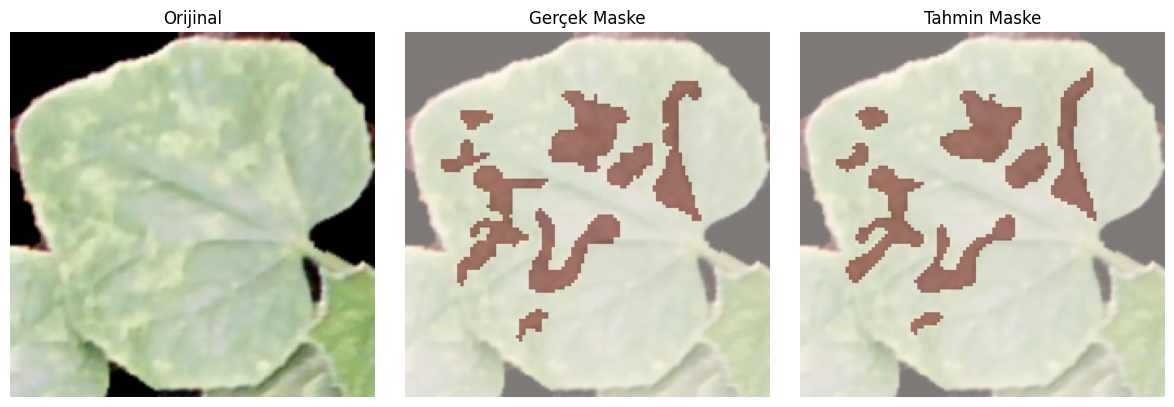

Gerçek oran: 0.170, Tahmin: 0.173


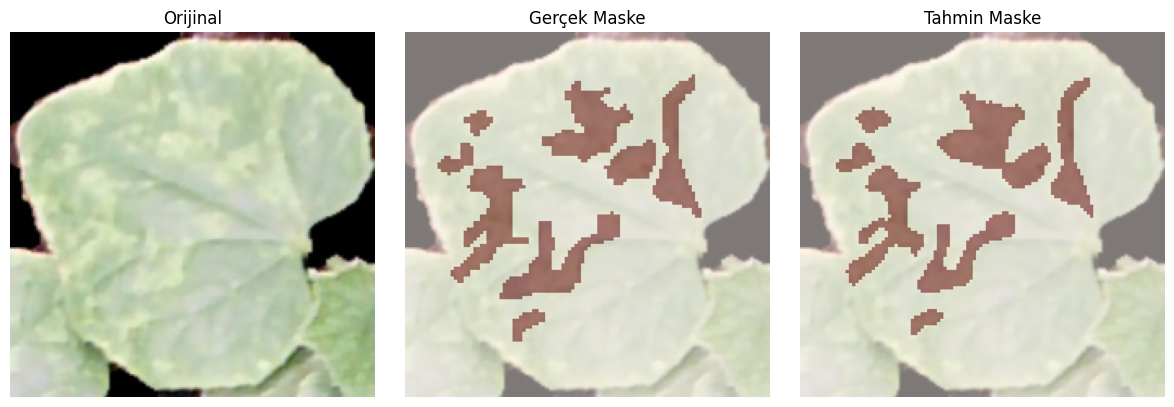

Gerçek oran: 0.261, Tahmin: 0.268


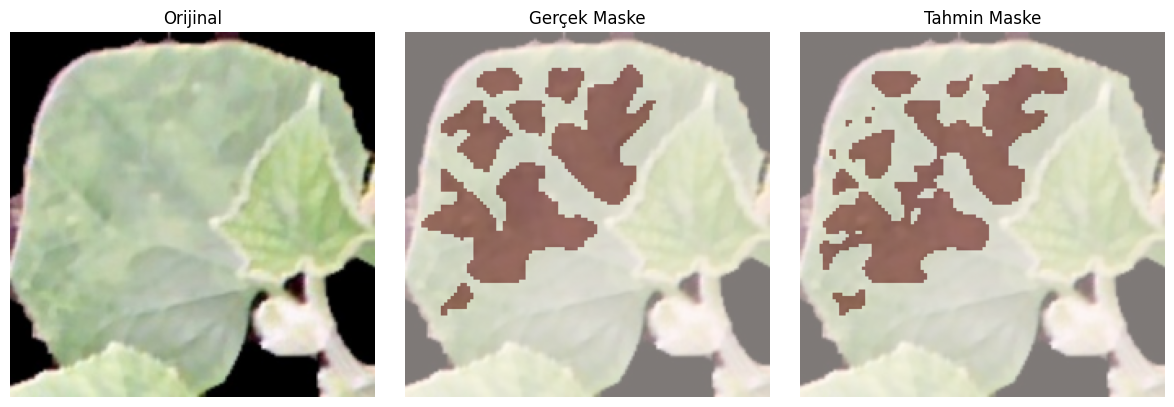

Gerçek oran: 0.026, Tahmin: 0.027


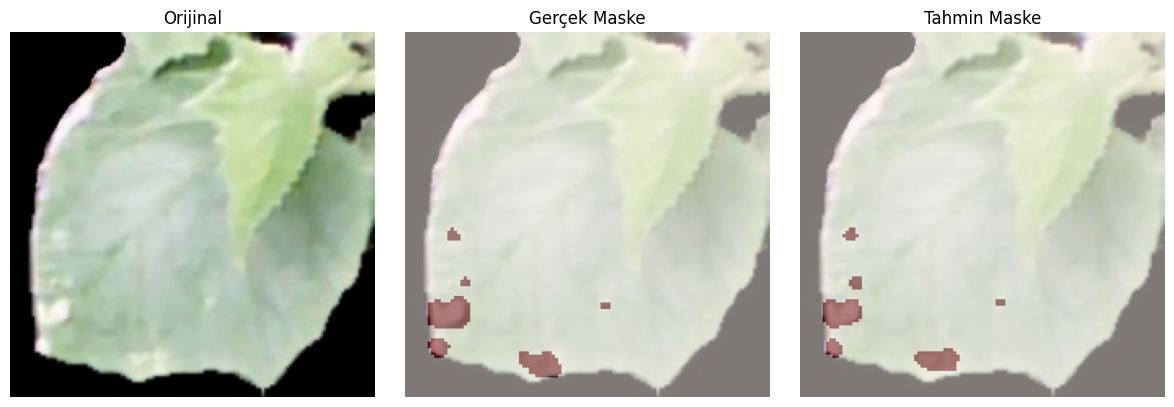

Gerçek oran: 0.017, Tahmin: 0.019


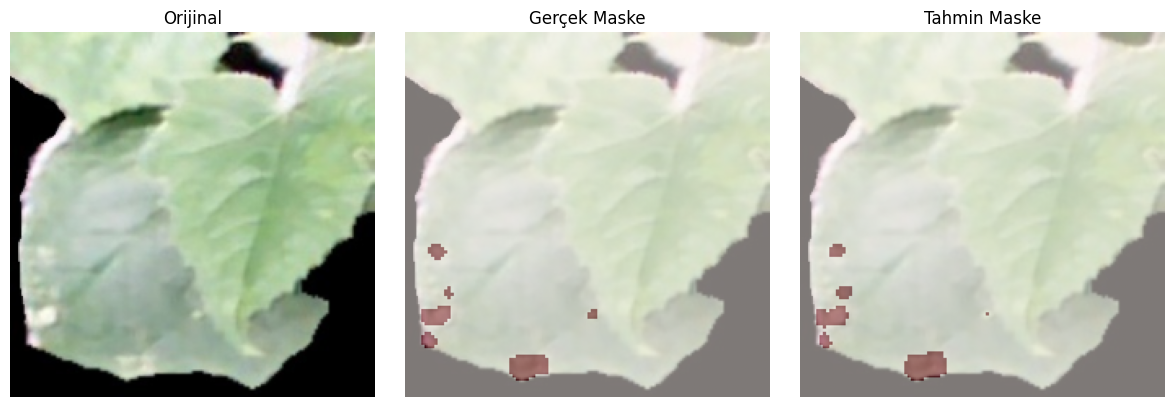

In [ ]:
import random
model.eval()
with torch.no_grad():
    idxs = random.sample(range(len(valid_loader.dataset)), 5)
    for idx in idxs:
        img, true_mask, ratio = valid_loader.dataset[idx]
        inp = img.unsqueeze(0).to(DEVICE)
        seg_logits, reg_pred = model(inp)
        pred_mask = (torch.sigmoid(seg_logits) > 0.5).float().cpu()

        print(f"Gerçek oran: {ratio.item():.3f}, Tahmin: {reg_pred.item():.3f}")
        viz_segmentation(img, true_mask, pred_mask[0])
